# **Intro**
In this notebook I set up semi-supervised VAE that disentangles the rotation and digits of MNIST numbers. 
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: rotation, digit, and everything else (slack).
To enforce this disentanglement, there are classification losses on the rotation and digit embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.
The model is depicted below.

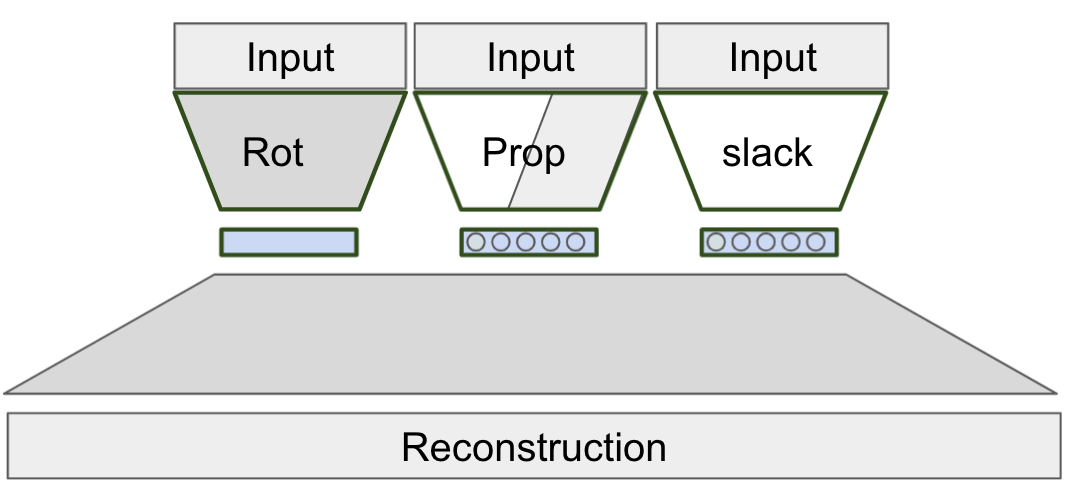


The experimental set-up is as follows:
The numbers are rotated 0, 15, 30, 45, 60, and 75 degrees. 
The model differentiates domains (rotations, referred to as *labels* in the code) from predicted values (digits, , referred to as *Y* in the code). 
The idea is to be able to provide correct labels in a new domain. 
The semi-supervision section has a new domain (30 degrees) without a Y (no digit).


This is analogous to the following situation: 
single-cell profiles where a patient or sequencing method is the domain (noise we would like to remove) and cell type (the label) is what we would like to predict.
This is done in a semi-supervised fashion because we would like to use bulk data in addition to single-cell.
However, bulk data is assumed to be a sum over many cell-types (i.e. we don't know the labels).
There is one simplification in this approach -- we predict a single-cell type for now.
Realistically, we predict a continuous vector of cell-type proportions.
Currently, we predict a 1-hot representation of cell-type identity.

Using both of these sources of data we hope that we can work on OOD stuff.
We focus on interpolation, not extrapolation, but this is not directly done in this notebook.

This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae


# **Imports**

In [1]:
# import the our code
import sys
sys.path.insert(1, '../../')
from sc_preprocessing import sc_preprocess

# general imports
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from scipy.stats import spearmanr, pearsonr


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale


# programming stuff
import time
import os, sys
import pickle
from pathlib import Path


# **Set up experiment parameters** 


In [2]:

n_train = 1000
batch_size = 500
Label_full_sm2 = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                              np.full(n_train, 2), np.full(n_train, 3),
                              np.full(n_train, 4), np.full(n_train, 5)], axis=0)
label_full_sm2 = to_categorical(Label_full_sm2)

Label_full = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                              np.full(n_train, 2), np.full(n_train, 3),
                              np.full(n_train, 4), np.full(n_train, 5),
                              np.full(n_train, 6), np.full(n_train, 7),
                              np.full(n_train, 8), np.full(n_train, 9),
                              np.full(n_train, 10), np.full(n_train, 11)], axis=0)
label_full = to_categorical(Label_full)

# indexes for the training/testing
idx_train_sm2 = np.where(np.logical_and(Label_full_sm2!=2, Label_full_sm2!=0))[0]
idx_3_sm2 = np.where(Label_full_sm2==2)[0]
idx_0_sm2 = np.where(Label_full_sm2==0)[0]

idx_train = np.where(np.logical_and(Label_full!=2, Label_full!=0))[0]
idx_3 = np.where(Label_full==2)[0]
idx_0 = np.where(Label_full==0)[0]


# **Load Data**

In [3]:

res_path = f"{os.getcwd()}/../../results/single_cell_data/diva_pbmc/"
bp_res_path = f"{os.getcwd()}/../../results/single_cell_data/bp_pbmc/"
cs_res_path = f"{os.getcwd()}/../../results/single_cell_data/cibersort_pbmc/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_pbmc_data/"

def read_gene_file(res_path, exp_id):
    gene_file = os.path.join(res_path, f"train-{exp_id}-DIVA_features.pkl")
    gene_path = Path(gene_file)
    gene_df_train = pickle.load( open( gene_path, "rb" ) )
    return gene_df_train

exp_id = "pbmc_rep1_sm2"
pbmc_rep1_sm2_enc = tf.keras.models.load_model(f"{res_path}/{exp_id}_encoder")
pbmc_rep1_sm2_X, pbmc_rep1_sm2_Y, _ = sc_preprocess.read_all_diva_files(data_path, range(6), exp_id)
pbmc_rep1_sm2_train = read_gene_file(res_path, exp_id)

exp_id = "pbmc_rep2_10xV2"
pbmc_rep2_10xV2_enc = tf.keras.models.load_model(f"{res_path}/{exp_id}_encoder")
pbmc_rep2_10xV2_X, pbmc_rep2_10xV2_Y, _ = sc_preprocess.read_all_diva_files(data_path, range(12), exp_id)
pbmc_rep2_10xV2_train = read_gene_file(res_path, exp_id)

exp_id = "pbmc_rep2_10xV2_sm2_cells"
pbmc_rep2_10xV2_sm2_cells_enc = tf.keras.models.load_model(f"{res_path}/{exp_id}_encoder")
pbmc_rep2_10xV2_sm2_cells_X, pbmc_rep2_10xV2_sm2_cells_Y, _ = sc_preprocess.read_all_diva_files(data_path, range(6), exp_id)
pbmc_rep2_10xV2_sm2_cells_train = read_gene_file(res_path, exp_id)

exp_id = "pbmc_rep1_10xV2a"
pbmc_rep1_10xV2a_enc = tf.keras.models.load_model(f"{res_path}/{exp_id}_encoder")
pbmc_rep1_10xV2a_X, pbmc_rep1_10xV2a_Y, _ = sc_preprocess.read_all_diva_files(data_path, range(12), exp_id)
pbmc_rep1_10xV2a_train = read_gene_file(res_path, exp_id)


exp_id = "pbmc_rep1_10xV2a_sm2_cells"
pbmc_rep1_10xV2a_sm2_cells_enc = tf.keras.models.load_model(f"{res_path}/{exp_id}_encoder")
pbmc_rep1_10xV2a_sm2_cells_X, pbmc_rep1_10xV2a_sm2_cells_Y, _ = sc_preprocess.read_all_diva_files(data_path, range(6), exp_id)
pbmc_rep1_10xV2a_sm2_cells_train = read_gene_file(res_path, exp_id)


2021-11-22 15:30:22.171248: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# **Make TSNE of raw and training data**

In [4]:
def make_tsne_fig(X_df, color_vec, ax, title):
    ## plot samples
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(X_df)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    plot_df['class'] = color_vec

    n_colors = len(np.unique(color_vec))
    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="class",
        palette=sns.color_palette("hls", n_colors),
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g



/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.013s...
[t-SNE] Computed neighbors for 1000 samples in 0.298s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5490927.164578
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.418591
[t-SNE] KL divergence after 300 iterations: 0.683309
(1000, 2)
(1000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.013s...
[t-SNE] Computed neighbors for 1000 samples in 0.317s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 41754.799909
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.996216
[t-SNE] KL divergence after 300 iterations: 0.649312
(1000, 2)
(1000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.013s...
[t-SNE] Computed neighbors for 1000 samples in 0.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 34069.520208
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.521000
[t-SNE] KL divergence after 300 iterations: 0.562371
(1000, 2)
(1000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.012s...
[t-SNE] Computed neighbors for 1000 samples in 0.217s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 39591.711632
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.512905
[t-SNE] KL divergence after 300 iterations: 0.665630
(1000, 2)
(1000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.012s...
[t-SNE] Computed neighbors for 1000 samples in 0.211s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 33609.007830
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.735916
[t-SNE] KL divergence after 300 iterations: 0.630999
(1000, 2)
(1000, 2)


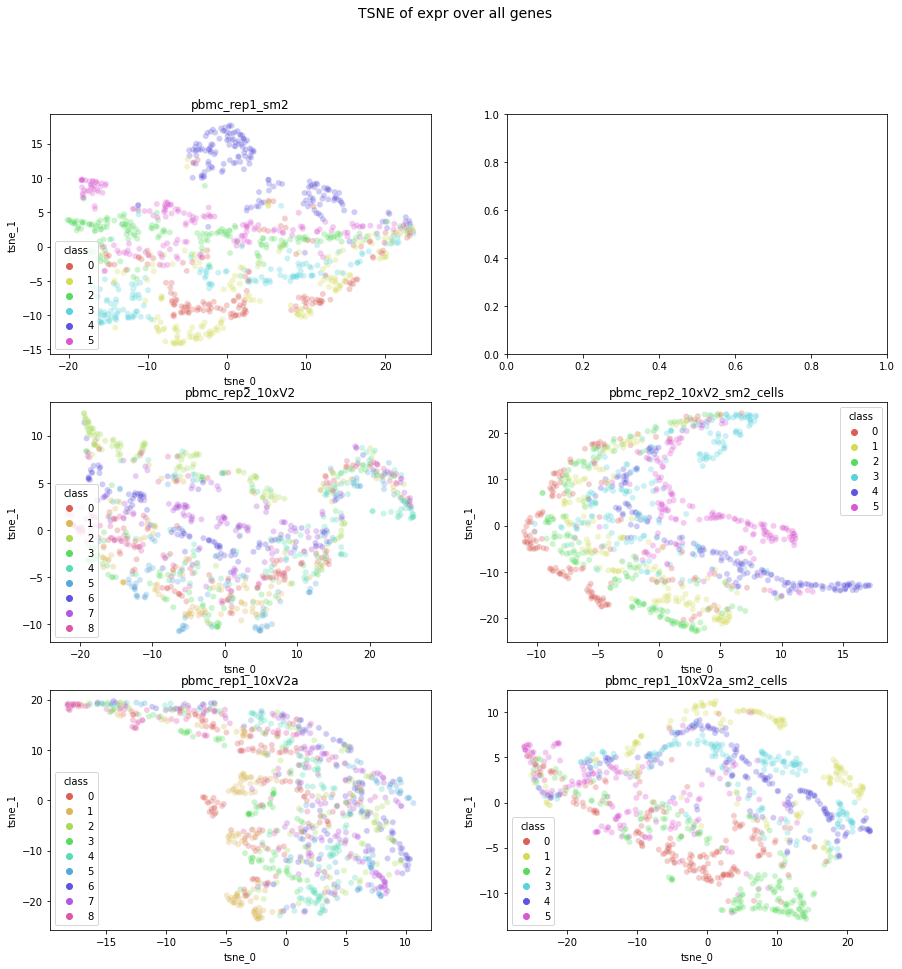

In [5]:
# plot over all genes

curr_idx = idx_0

fig, axs = plt.subplots(3, 2, figsize=(15,15))
tmp_Y = pbmc_rep1_sm2_Y.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
make_tsne_fig(pbmc_rep1_sm2_X.iloc[curr_idx], tmp_Y, ax=axs[0,0], title="pbmc_rep1_sm2")

tmp_Y = pbmc_rep2_10xV2_Y.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
make_tsne_fig(pbmc_rep2_10xV2_X.iloc[curr_idx], tmp_Y, ax=axs[1,0], title="pbmc_rep2_10xV2")

tmp_Y = pbmc_rep2_10xV2_sm2_cells_Y.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
make_tsne_fig(pbmc_rep2_10xV2_sm2_cells_X.iloc[curr_idx], tmp_Y, ax=axs[1,1], title="pbmc_rep2_10xV2_sm2_cells")

tmp_Y = pbmc_rep1_10xV2a_Y.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
make_tsne_fig(pbmc_rep1_10xV2a_X.iloc[curr_idx], tmp_Y, ax=axs[2,0], title="pbmc_rep1_10xV2a")

tmp_Y = pbmc_rep1_10xV2a_sm2_cells_Y.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
make_tsne_fig(pbmc_rep1_10xV2a_sm2_cells_X.iloc[curr_idx], tmp_Y, ax=axs[2,1], title="pbmc_rep1_10xV2a_sm2_cells")

fig.suptitle("TSNE of expr over all genes", fontsize=14)

fig.show()

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 5335483.405076
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.367542
[t-SNE] KL divergence after 300 iterations: 0.681275
(1000, 2)
(1000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 41303.340238
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.900940
[t-SNE] KL divergence after 300 iterations: 0.687589
(1000, 2)
(1000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 33630.418348
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.418610
[t-SNE] KL divergence after 300 iterations: 0.559655
(1000, 2)
(1000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.061s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 39219.168786
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.438732
[t-SNE] KL divergence after 300 iterations: 0.673008
(1000, 2)
(1000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.057s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 33215.448501
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.668732
[t-SNE] KL divergence after 300 iterations: 0.623018
(1000, 2)
(1000, 2)


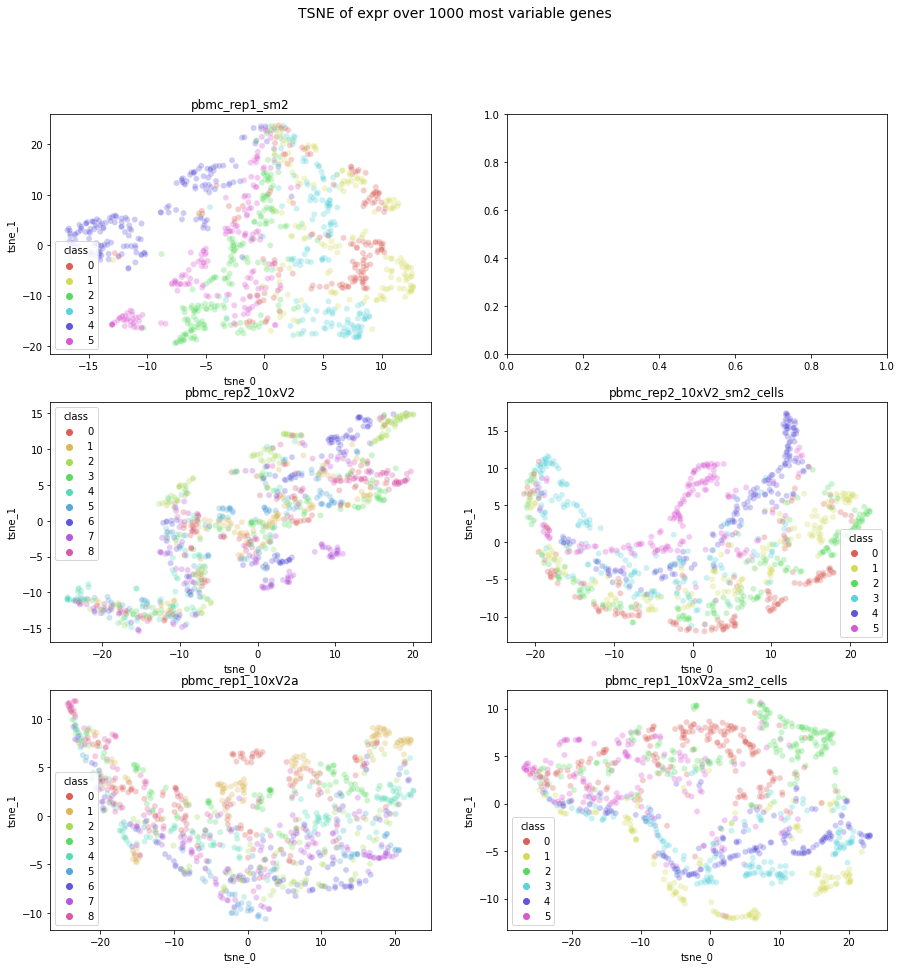

In [6]:
# plot over only genes used in testing

curr_idx = idx_0

fig, axs = plt.subplots(3, 2, figsize=(15,15))
tmp_Y = pbmc_rep1_sm2_Y.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
tmp_X = pbmc_rep1_sm2_X[pbmc_rep1_sm2_train["gene_ids"]]
make_tsne_fig(tmp_X.iloc[curr_idx,], tmp_Y, ax=axs[0,0], title="pbmc_rep1_sm2")

tmp_Y = pbmc_rep2_10xV2_Y.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
tmp_X = pbmc_rep2_10xV2_X[pbmc_rep2_10xV2_train["gene_ids"]]
make_tsne_fig(tmp_X.iloc[curr_idx], tmp_Y, ax=axs[1,0], title="pbmc_rep2_10xV2")

tmp_Y = pbmc_rep2_10xV2_sm2_cells_Y.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
tmp_X = pbmc_rep2_10xV2_sm2_cells_X[pbmc_rep2_10xV2_sm2_cells_train["gene_ids"]]
make_tsne_fig(tmp_X.iloc[curr_idx], tmp_Y, ax=axs[1,1], title="pbmc_rep2_10xV2_sm2_cells")

tmp_Y = pbmc_rep1_10xV2a_Y.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
tmp_X = pbmc_rep1_10xV2a_X[pbmc_rep1_10xV2a_train["gene_ids"]]
make_tsne_fig(tmp_X.iloc[curr_idx], tmp_Y, ax=axs[2,0], title="pbmc_rep1_10xV2a")

tmp_Y = pbmc_rep1_10xV2a_sm2_cells_Y.iloc[curr_idx]
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
tmp_X = pbmc_rep1_10xV2a_sm2_cells_X[pbmc_rep1_10xV2a_sm2_cells_train["gene_ids"]]
make_tsne_fig(tmp_X.iloc[curr_idx], tmp_Y, ax=axs[2,1], title="pbmc_rep1_10xV2a_sm2_cells")

fig.suptitle("TSNE of expr over 1000 most variable genes", fontsize=14)

fig.show()


# **Plot Loss Curves**

In [4]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g





## **Total Loss**

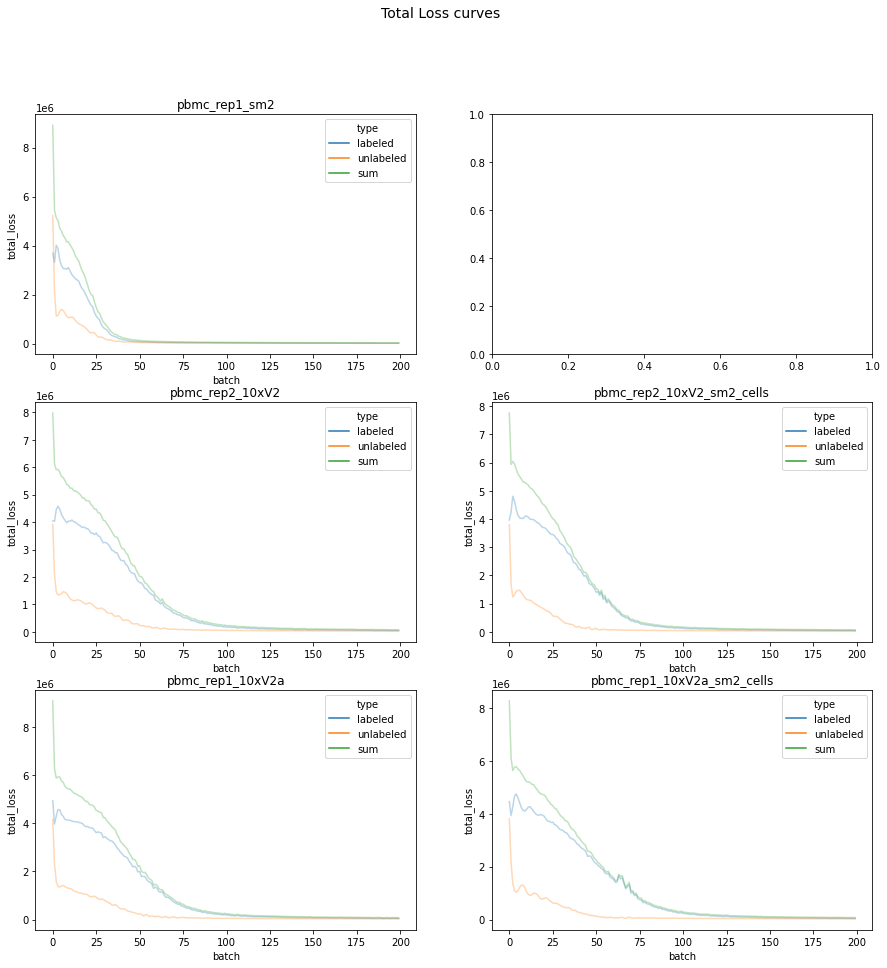

In [8]:

loss_to_plot = "total_loss"
fig, axs = plt.subplots(3, 2, figsize=(15,15))
loss_df1 = read_loss_file(res_path, exp_id="pbmc_rep1_sm2")
make_loss_fig(loss_df1, ax=axs[0,0], title="pbmc_rep1_sm2", loss_to_plot=loss_to_plot)

loss_df2 = read_loss_file(res_path, exp_id="pbmc_rep2_10xV2")
make_loss_fig(loss_df2, ax=axs[1,0], title="pbmc_rep2_10xV2", loss_to_plot=loss_to_plot)

loss_df3 = read_loss_file(res_path, exp_id="pbmc_rep2_10xV2_sm2_cells")
make_loss_fig(loss_df3, ax=axs[1,1], title="pbmc_rep2_10xV2_sm2_cells", loss_to_plot=loss_to_plot)

loss_df4 = read_loss_file(res_path, exp_id="pbmc_rep1_10xV2a")
make_loss_fig(loss_df4, ax=axs[2,0], title="pbmc_rep1_10xV2a", loss_to_plot=loss_to_plot)

loss_df5 = read_loss_file(res_path, exp_id="pbmc_rep1_10xV2a_sm2_cells")
make_loss_fig(loss_df5, ax=axs[2,1], title="pbmc_rep1_10xV2a_sm2_cells", loss_to_plot=loss_to_plot)

fig.suptitle("Total Loss curves", fontsize=14)

fig.show()

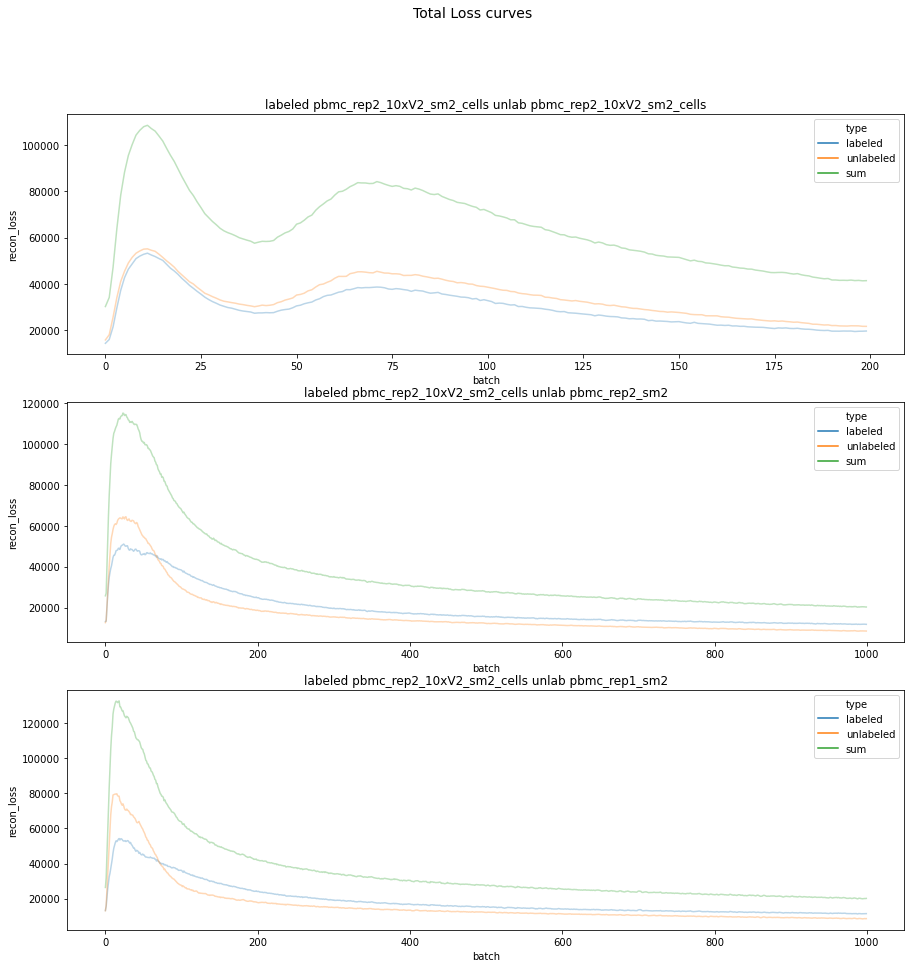

In [8]:
res_path = f"{os.getcwd()}/../../results/single_cell_data/diva_pbmc/"
bp_res_path = f"{os.getcwd()}/../../results/single_cell_data/bp_pbmc/"
cs_res_path = f"{os.getcwd()}/../../results/single_cell_data/cibersort_pbmc/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_pbmc_data/"


exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep2_sm2"

loss_to_plot = "recon_loss"
fig, axs = plt.subplots(3, figsize=(15,15))

exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep2_10xV2_sm2_cells"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[0], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep2_sm2"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[1], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep1_sm2"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[2], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)



fig.suptitle("Total Loss curves", fontsize=14)

fig.show()

## **Reconstruction Loss**

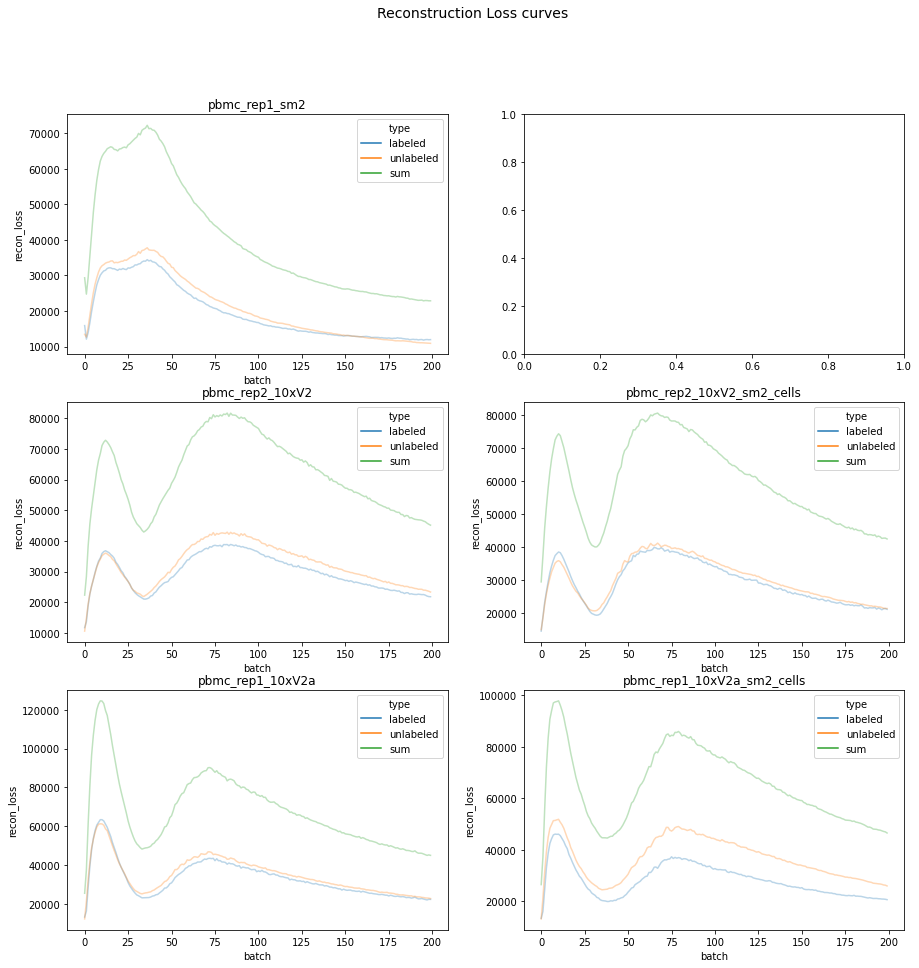

In [9]:
loss_to_plot = "recon_loss"
fig, axs = plt.subplots(3, 2, figsize=(15,15))
loss_df1 = read_loss_file(res_path, exp_id="pbmc_rep1_sm2")
make_loss_fig(loss_df1, ax=axs[0,0], title="pbmc_rep1_sm2", loss_to_plot=loss_to_plot)

loss_df2 = read_loss_file(res_path, exp_id="pbmc_rep2_10xV2")
make_loss_fig(loss_df2, ax=axs[1,0], title="pbmc_rep2_10xV2", loss_to_plot=loss_to_plot)

loss_df3 = read_loss_file(res_path, exp_id="pbmc_rep2_10xV2_sm2_cells")
make_loss_fig(loss_df3, ax=axs[1,1], title="pbmc_rep2_10xV2_sm2_cells", loss_to_plot=loss_to_plot)

loss_df4 = read_loss_file(res_path, exp_id="pbmc_rep1_10xV2a")
make_loss_fig(loss_df4, ax=axs[2,0], title="pbmc_rep1_10xV2a", loss_to_plot=loss_to_plot)

loss_df5 = read_loss_file(res_path, exp_id="pbmc_rep1_10xV2a_sm2_cells")
make_loss_fig(loss_df5, ax=axs[2,1], title="pbmc_rep1_10xV2a_sm2_cells", loss_to_plot=loss_to_plot)

fig.suptitle("Reconstruction Loss curves", fontsize=14)

fig.show()

## **Proportion Loss**

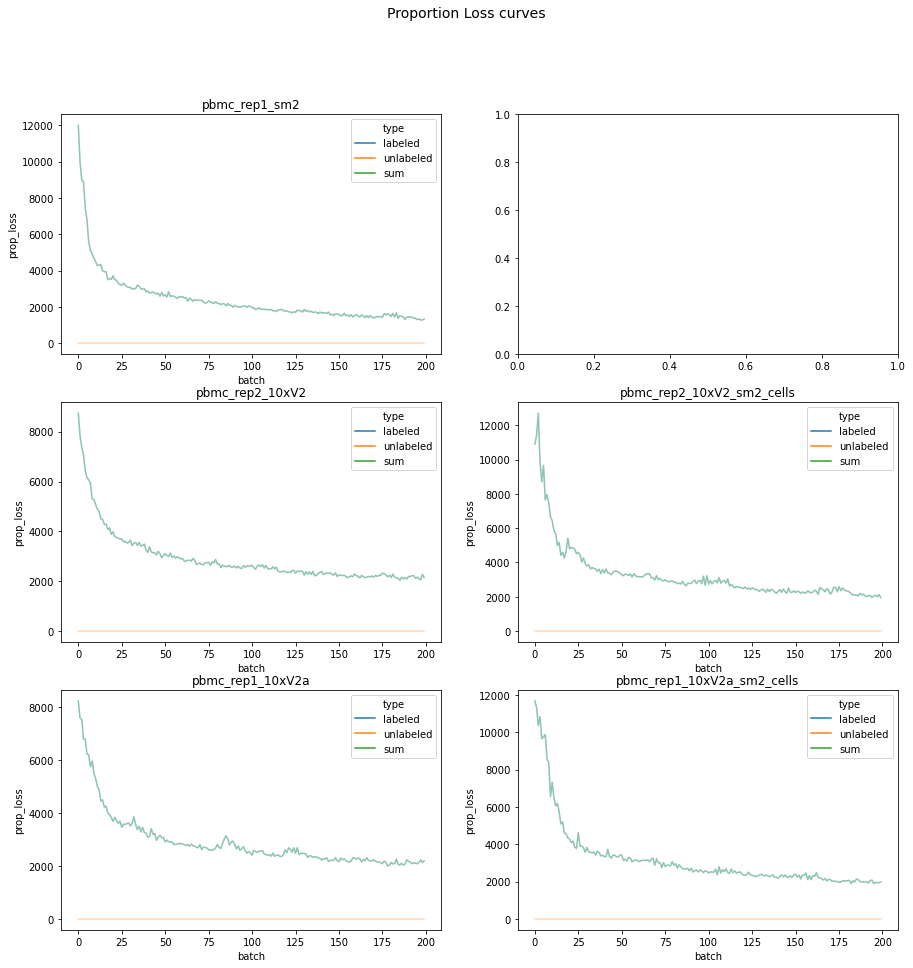

In [10]:
loss_to_plot = "prop_loss"
fig, axs = plt.subplots(3, 2, figsize=(15,15))
loss_df1 = read_loss_file(res_path, exp_id="pbmc_rep1_sm2")
make_loss_fig(loss_df1, ax=axs[0,0], title="pbmc_rep1_sm2", loss_to_plot=loss_to_plot)

loss_df2 = read_loss_file(res_path, exp_id="pbmc_rep2_10xV2")
make_loss_fig(loss_df2, ax=axs[1,0], title="pbmc_rep2_10xV2", loss_to_plot=loss_to_plot)

loss_df3 = read_loss_file(res_path, exp_id="pbmc_rep2_10xV2_sm2_cells")
make_loss_fig(loss_df3, ax=axs[1,1], title="pbmc_rep2_10xV2_sm2_cells", loss_to_plot=loss_to_plot)

loss_df4 = read_loss_file(res_path, exp_id="pbmc_rep1_10xV2a")
make_loss_fig(loss_df4, ax=axs[2,0], title="pbmc_rep1_10xV2a", loss_to_plot=loss_to_plot)

loss_df5 = read_loss_file(res_path, exp_id="pbmc_rep1_10xV2a_sm2_cells")
make_loss_fig(loss_df5, ax=axs[2,1], title="pbmc_rep1_10xV2a_sm2_cells", loss_to_plot=loss_to_plot)

fig.suptitle("Proportion Loss curves", fontsize=14)

fig.show()

## **Sample Prediction Loss**

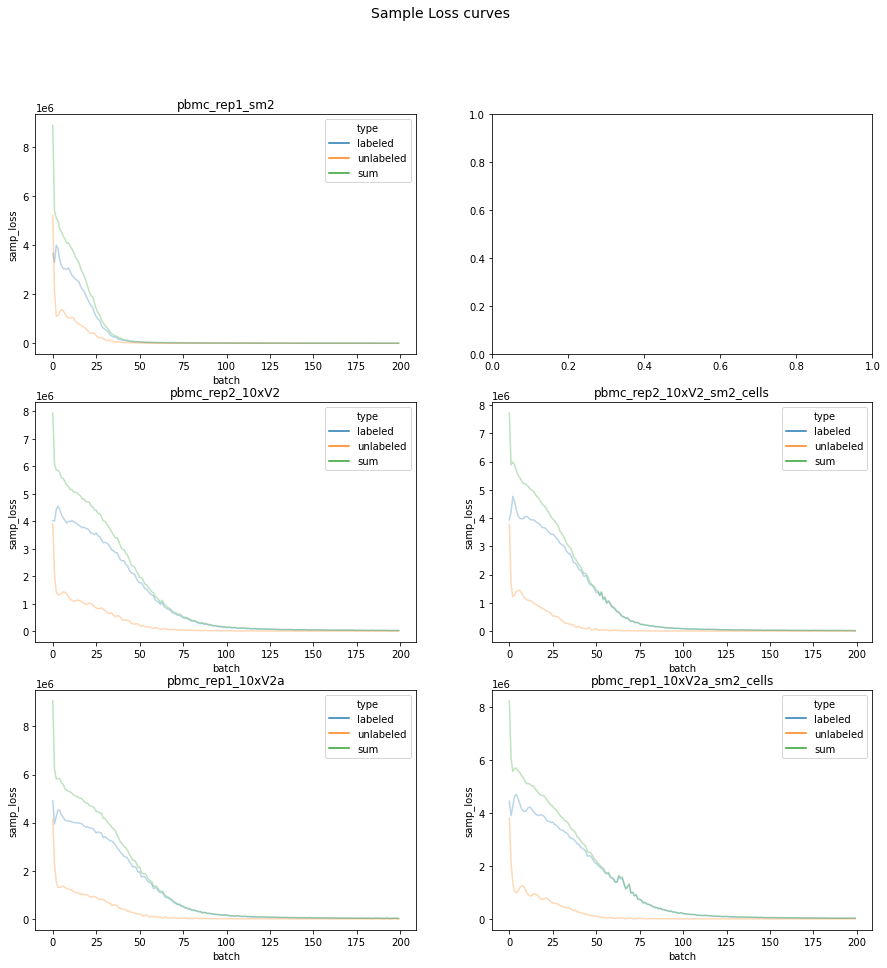

In [11]:
loss_to_plot = "samp_loss"
fig, axs = plt.subplots(3, 2, figsize=(15,15))
loss_df1 = read_loss_file(res_path, exp_id="pbmc_rep1_sm2")
make_loss_fig(loss_df1, ax=axs[0,0], title="pbmc_rep1_sm2", loss_to_plot=loss_to_plot)

loss_df2 = read_loss_file(res_path, exp_id="pbmc_rep2_10xV2")
make_loss_fig(loss_df2, ax=axs[1,0], title="pbmc_rep2_10xV2", loss_to_plot=loss_to_plot)

loss_df3 = read_loss_file(res_path, exp_id="pbmc_rep2_10xV2_sm2_cells")
make_loss_fig(loss_df3, ax=axs[1,1], title="pbmc_rep2_10xV2_sm2_cells", loss_to_plot=loss_to_plot)

loss_df4 = read_loss_file(res_path, exp_id="pbmc_rep1_10xV2a")
make_loss_fig(loss_df4, ax=axs[2,0], title="pbmc_rep1_10xV2a", loss_to_plot=loss_to_plot)

loss_df5 = read_loss_file(res_path, exp_id="pbmc_rep1_10xV2a_sm2_cells")
make_loss_fig(loss_df5, ax=axs[2,1], title="pbmc_rep1_10xV2a_sm2_cells", loss_to_plot=loss_to_plot)

fig.suptitle("Sample Loss curves", fontsize=14)

fig.show()

# **Plot Encodings**

## TSNE on training data

Here we are now interested in training on pbmc_rep1_10xV2a and testing on other settings.
So we will first show how well we perform on our training data

In [12]:
   
def get_tsne_for_plotting(encodings):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g




Number unique Y: 9


2021-11-22 15:37:08.009147: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 3.729s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 8916.938351
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.228340
[t-SNE] KL divergence after 300 iterations: 2.740418
(10000, 2)
(10000, 2)


/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 3.415s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 10197.516267
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.862328
[t-SNE] KL divergence after 300 iterations: 2.019117
(10000, 2)
(10000, 2)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 10000 samples in 1.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 618.976563
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.047523
[t-SNE] KL divergence after 300 iterations: 2.818765
(10000, 2)
(10000, 2)


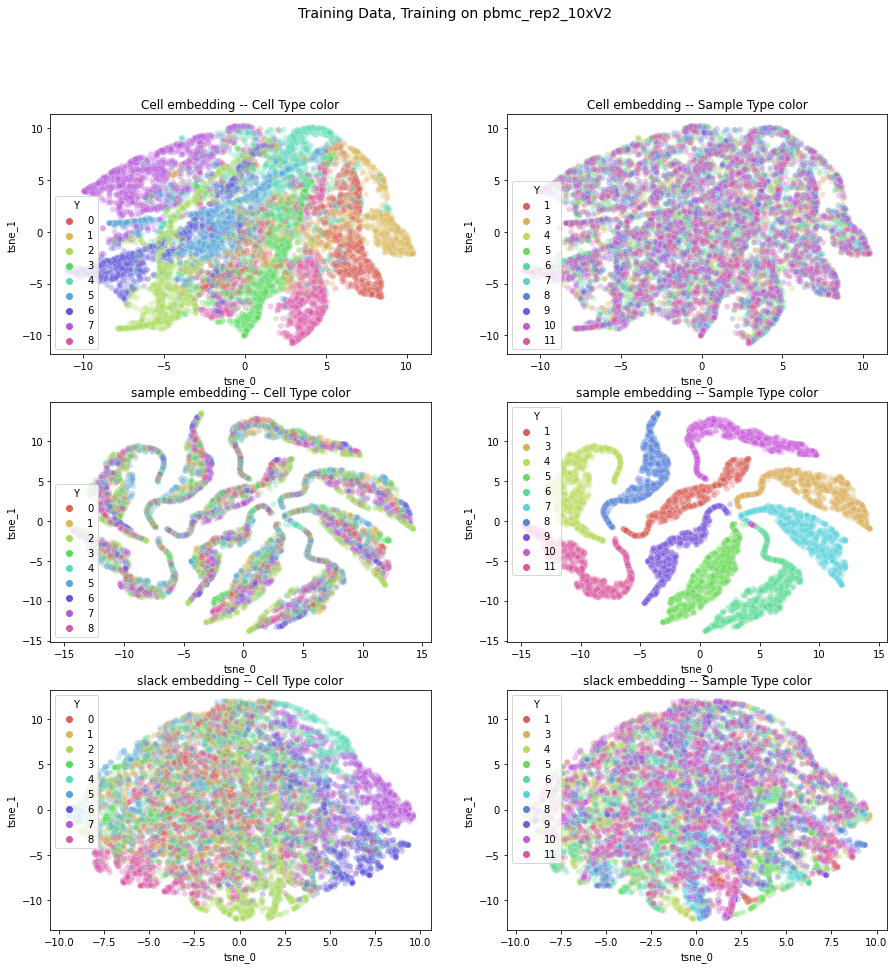

In [13]:

# plot proportions on TRAINING DATA
X_temp = pbmc_rep2_10xV2_X[pbmc_rep2_10xV2_train["gene_ids"]]
X_temp = X_temp.to_numpy()
X_temp = X_temp[idx_train]

Y_temp = pbmc_rep2_10xV2_Y
Y_temp = np.argmax(Y_temp.to_numpy(), axis=1)
Y_temp = Y_temp[idx_train]

label_temp = Label_full[idx_train]


print(f"Number unique Y: {len(np.unique(Y_temp))}")

_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _ = pbmc_rep2_10xV2_enc.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)


fig, axs = plt.subplots(3, 2, figsize=(15,15))

plot_df = get_tsne_for_plotting(np.asarray(mu_prop))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")


fig.suptitle("Training Data, Training on pbmc_rep2_10xV2", fontsize=14)

fig.show()



# **Predict on our noise**

## Set-up Methods

In [14]:
def read_diva_result_file(res_path, train_id, test_id):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-DIVA.pkl")
    res_path = Path(res_file)
    res_df = pickle.load( open( res_path, "rb" ) )
    return res_df

def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_prop.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


In [15]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df


def get_cell_type_errors(y_true_all, y_est_all, cell_type, cell_idx):

  for curr_cell in y_true_all.columns:
    y_true = y_true_all[[curr_cell]]
    y_est = y_est_all[[curr_cell]]

    mse_err = mean_sqr_error(y_true, y_est)

    print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

    spr_err = spearmanr(y_true.astype(float), y_est.astype(float))[0]
    print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

    pear_err = pearsonr(y_true.astype(float), y_est.astype(float))[0]
    print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

    error_list = [mse_err, spr_err, pear_err]
    plot_df = [item for sublist in error_list for item in sublist]
    plot_df = pd.DataFrame(plot_df)
    plot_df.columns = ["error"]
    plot_df["error_type"] = ["MSQ"] + ["SPR"] + ["PEAR"]

  return plot_df

In [16]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g

## First test only on re-sampled noise

We plot the Mean Squared Error (MSQ) and Pearson correlation with ground truth cell-type proportions.
This is compared between BuDDI and BayesPrism (BP)

MSqE mean: 0.0037948191307075733, median: 0.002940750169817709, max: 0.030154916764500956
Spearman mean: 0.7204840573842873, median: 0.7714285714285715, max: 1.0
Pearson mean: 0.9468131065188695, median: 0.9762662777289771, max: 0.9999972625907113
MSqE mean: 0.014395927908188014, median: 0.00427505906434013, max: 0.049858122886909086
Spearman mean: 0.7452701442842412, median: 0.7955585856995542, max: 1.0
Pearson mean: 0.704189997663708, median: 0.9308795743700935, max: 0.9999995094578881


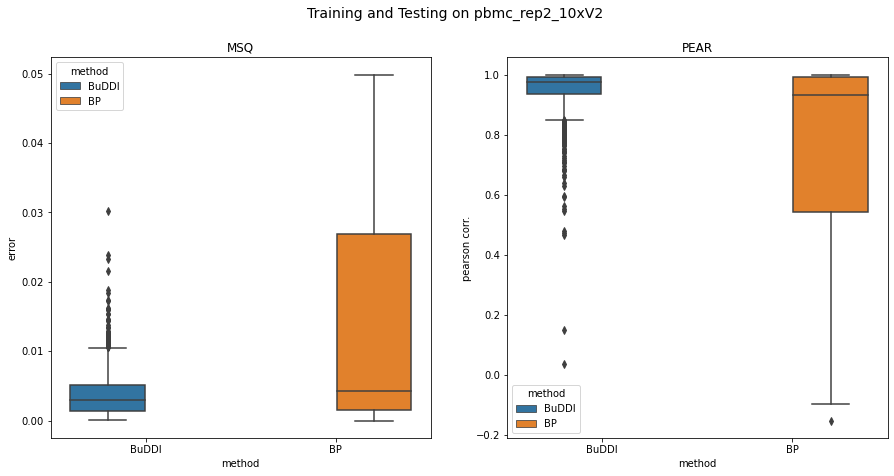

In [17]:
# first we test within the same sample
within_sample_test_diva  = read_diva_result_file(res_path, "pbmc_rep2_10xV2_sm2_cells", "pbmc_rep2_10xV2_sm2_cells")
within_sample_test_bp  = read_bp_result_file(bp_res_path, "pbmc_rep2_10xV2_sm2_cells_0", "pbmc_rep2_10xV2_sm2_cells_0", num_samp=20)
within_sample_test_bp = within_sample_test_bp.reindex(columns=within_sample_test_diva.columns, fill_value=0)

_, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 0, "pbmc_rep2_10xV2_sm2_cells")

Y_test_df = Y_test_df[within_sample_test_diva.columns]
Y_test = Y_test_df.to_numpy()

within_sample_test_bp = within_sample_test_bp[within_sample_test_diva.columns]

biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())
#biorep_diva_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_diva.to_numpy()))
#biorep_bp_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_bp.to_numpy()))

biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

plot_df = pd.concat([biorep_diva_err, biorep_bp_err])
#plot_df = biorep_diva_err

fig, axs = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")
fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

Now we plot the correlation across samples for a single cell type.
This is compared between BuDDI and BayesPrism (BP)

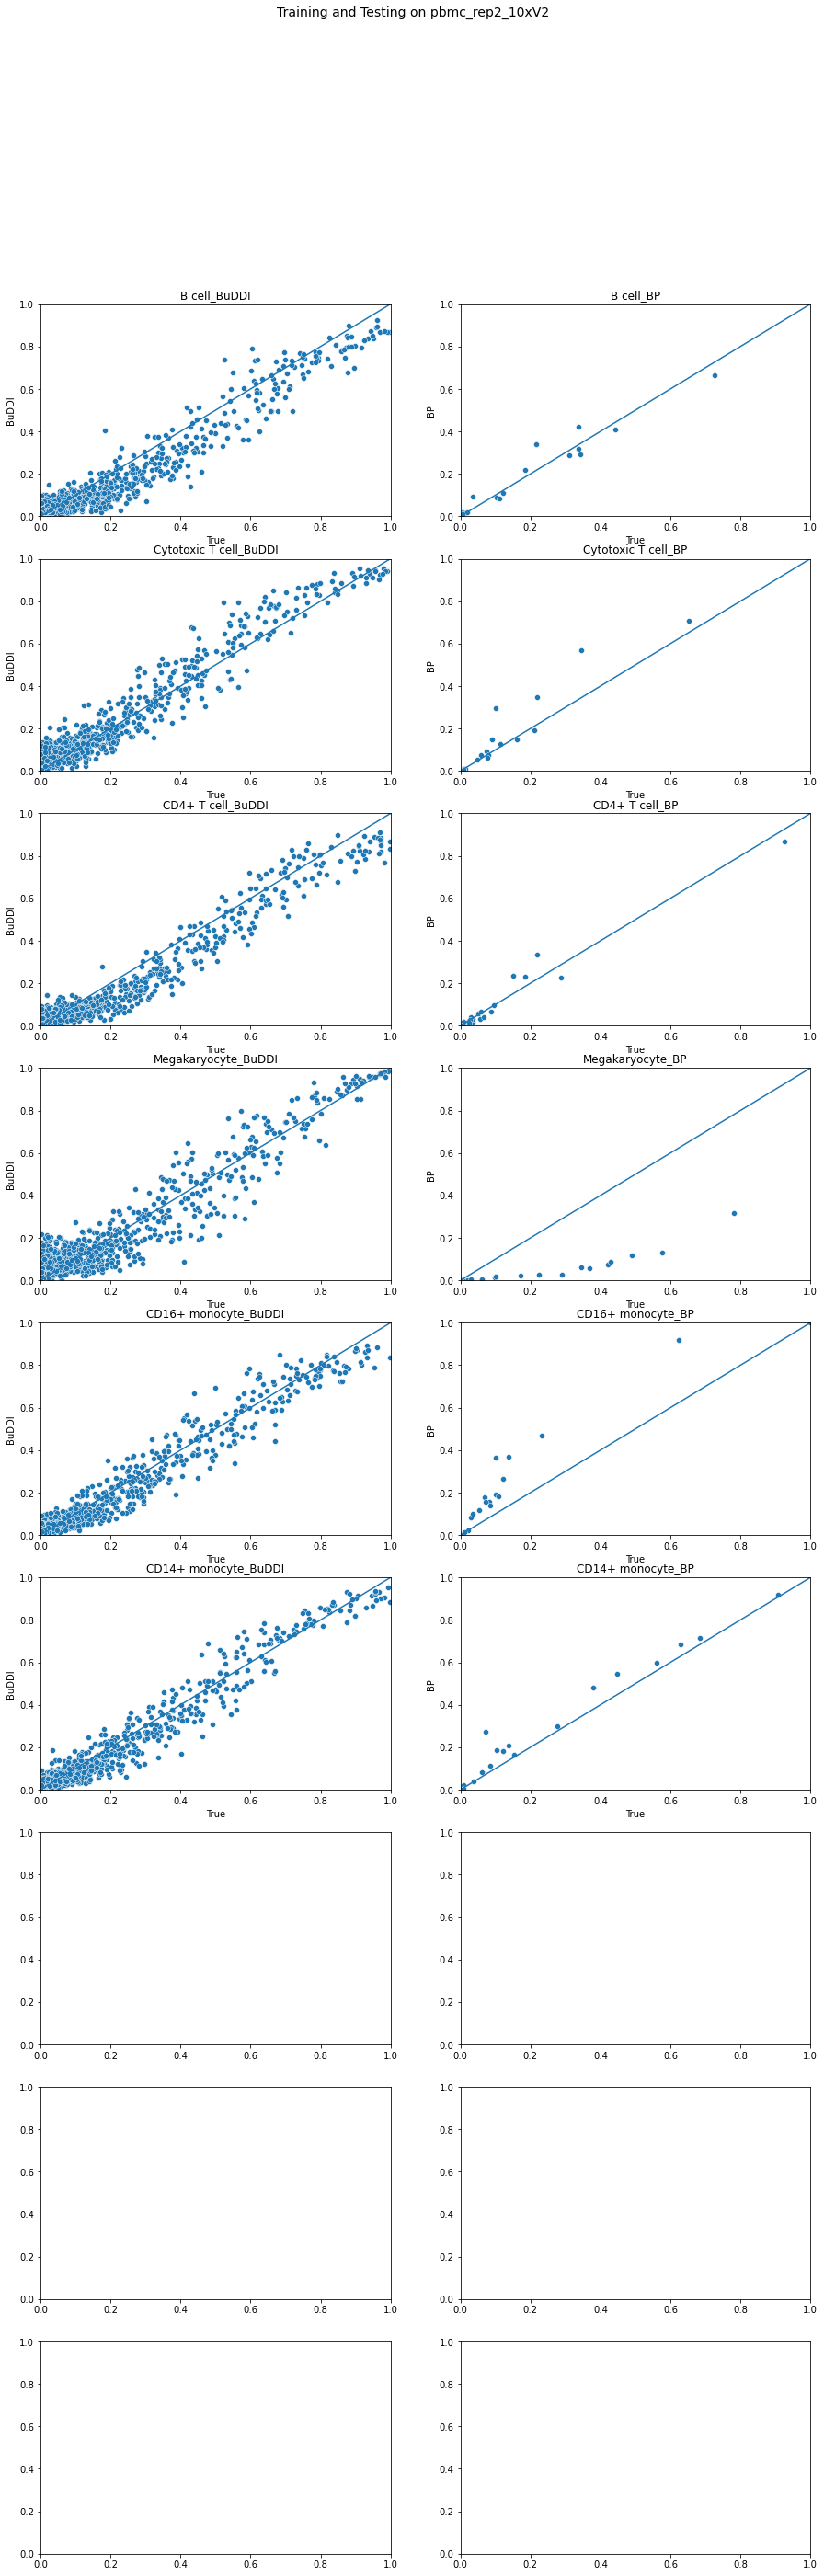

In [18]:

fig, axs = plt.subplots(9, 2, figsize=(15,45))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()



## Second, test on a different biological replicate, but same sequencer

MSqE mean: 0.005938557509140446, median: 0.00427047096491609, max: 0.047430274499560256
Spearman mean: 0.6738207018833197, median: 0.7142857142857143, max: 1.0
Pearson mean: 0.9159606026605354, median: 0.9649904212387728, max: 0.9999986851981084
MSqE mean: 0.01017492590287414, median: 0.0070366794548632015, max: 0.03687404575141466
Spearman mean: 0.6663591632170801, median: 0.7142857142857143, max: 1.0
Pearson mean: 0.8575672585972847, median: 0.9412127808107202, max: 0.9987166776926852


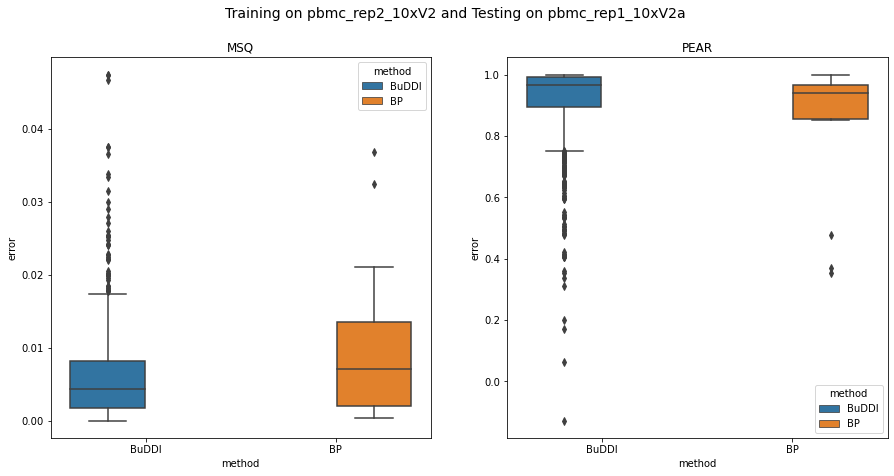

In [19]:
# first we test within the same sample
within_sample_test_diva  = read_diva_result_file(res_path, "pbmc_rep2_10xV2_sm2_cells", "pbmc_rep1_10xV2a_sm2_cells")
within_sample_test_bp  = read_bp_result_file(bp_res_path, "pbmc_rep2_10xV2_sm2_cells_0", "pbmc_rep1_10xV2a_sm2_cells_0", num_samp=20)
within_sample_test_bp = within_sample_test_bp.reindex(columns=within_sample_test_diva.columns, fill_value=0)

_, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 0, "pbmc_rep1_10xV2a_sm2_cells")

Y_test_df = Y_test_df[within_sample_test_diva.columns]
Y_test = Y_test_df.to_numpy()

biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())
#biorep_diva_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_diva.to_numpy()))
#biorep_bp_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_bp.to_numpy()))

biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

plot_df = pd.concat([biorep_diva_err, biorep_bp_err])
#plot_df = biorep_diva_err

fig, axs = plt.subplots(1, 2, figsize=(15,7))

sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
fig.suptitle("Training on pbmc_rep2_10xV2 and Testing on pbmc_rep1_10xV2a", fontsize=14)

fig.show()


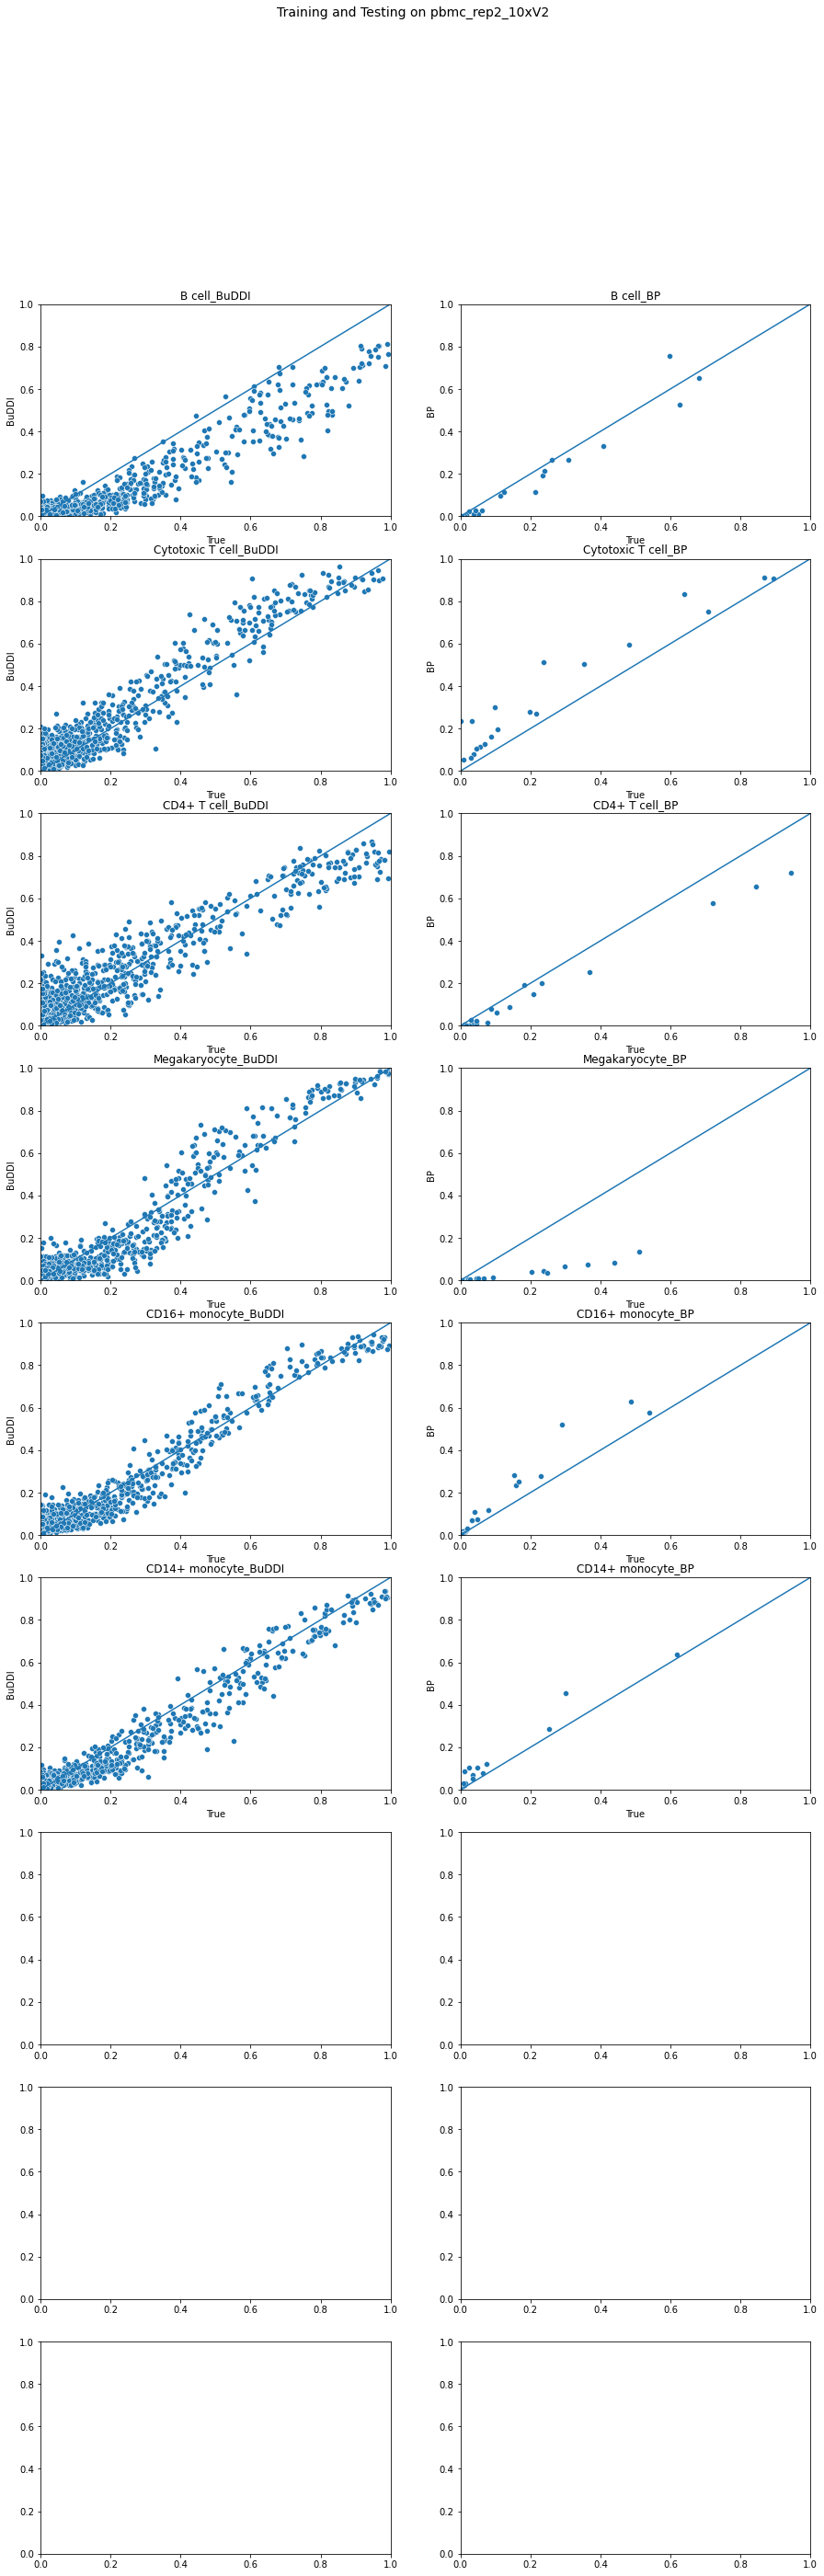

In [20]:

fig, axs = plt.subplots(9, 2, figsize=(15,45))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()



## Now test across bio+tech replicates

In [21]:
def run_analysis(res_path, data_path, num_samp_bp, train_id, test_id):

    bp_train = f"{train_id}_0"
    bp_test = f"{test_id}_0"

    # across rep and tech
    within_sample_test_diva  = read_diva_result_file(res_path, train_id, test_id)
    within_sample_test_bp  = read_bp_result_file(bp_res_path, bp_train, bp_test, num_samp=num_samp_bp)
    within_sample_test_bp = within_sample_test_bp.reindex(columns=within_sample_test_diva.columns, fill_value=0)

    X_test, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 0, test_id)
    Y_test_df = Y_test_df.reindex(columns=within_sample_test_diva.columns, fill_value=0)
    Y_test = Y_test_df.to_numpy()

    biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
    biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())
    #biorep_diva_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_diva.to_numpy()))
    #biorep_bp_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_bp.to_numpy()))

    biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
    biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

    biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
    biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

    return plot_df, Y_test_df, within_sample_test_diva, within_sample_test_bp


In [22]:
num_samp_bp = 20
train_id = "pbmc_rep2_10xV2_sm2_cells"
test_id = "pbmc_rep2_10xV2_sm2_cells"
plot_df, _, _, _ = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id)

MSqE mean: 0.0037948191307075733, median: 0.002940750169817709, max: 0.030154916764500956
Spearman mean: 0.7204840573842873, median: 0.7714285714285715, max: 1.0
Pearson mean: 0.9468131065188695, median: 0.9762662777289771, max: 0.9999972625907113
MSqE mean: 0.014395927908188014, median: 0.00427505906434013, max: 0.049858122886909086
Spearman mean: 0.7452701442842412, median: 0.7955585856995542, max: 1.0
Pearson mean: 0.704189997663708, median: 0.9308795743700935, max: 0.9999995094578881


In [23]:
num_samp_bp = 20
train_id = "pbmc_rep2_10xV2_sm2_cells"
test_id = "pbmc_rep1_10xV2a_sm2_cells"
plot_df, _, _, _ = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id)

MSqE mean: 0.005938557509140446, median: 0.00427047096491609, max: 0.047430274499560256
Spearman mean: 0.6738207018833197, median: 0.7142857142857143, max: 1.0
Pearson mean: 0.9159606026605354, median: 0.9649904212387728, max: 0.9999986851981084
MSqE mean: 0.01017492590287414, median: 0.0070366794548632015, max: 0.03687404575141466
Spearman mean: 0.6663591632170801, median: 0.7142857142857143, max: 1.0
Pearson mean: 0.8575672585972847, median: 0.9412127808107202, max: 0.9987166776926852


In [24]:
num_samp_bp = 20
train_id = "pbmc_rep2_10xV2_sm2_cells"
test_id = "pbmc_rep1_sm2"
plot_df, _, _, _ = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id)

MSqE mean: 0.07450695686661296, median: 0.0644431026799489, max: 0.2752255309107398
Spearman mean: 0.26617255371222515, median: 0.3142857142857143, max: 1.0
Pearson mean: 0.34742990910567584, median: 0.3416945684833773, max: 0.9999930770844236
MSqE mean: 0.005929198046023378, median: 0.00601013636529537, max: 0.014744736467065783
Spearman mean: 0.6609335697069522, median: 0.6952045590342637, max: 1.0
Pearson mean: 0.879310045724633, median: 0.9647980649618086, max: 0.997399505503895


In [25]:
num_samp_bp = 20
train_id = "pbmc_rep1_sm2"
test_id = "pbmc_rep1_sm2"
plot_df, _, _, _ = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id)

MSqE mean: 0.0015228962547273834, median: 0.001100278714602625, max: 0.01786640654527014
Spearman mean: 0.8148707024457889, median: 0.8857142857142858, max: 1.0
Pearson mean: 0.9760135935070368, median: 0.9901041826179264, max: 0.9999779851205943
MSqE mean: 0.0017630749818521789, median: 0.0012570750374756917, max: 0.008679943684722547
Spearman mean: 0.9108762521644879, median: 0.920751124059219, max: 1.0
Pearson mean: 0.9578992474223404, median: 0.9777126985906464, max: 0.999999925766822


MSqE mean: 0.10053172164915974, median: 0.10071960239764635, max: 0.27302961452108393
Spearman mean: 0.3426486143504686, median: 0.3714285714285715, max: 1.0
Pearson mean: 0.202091352761874, median: 0.09828465748874797, max: 0.9999963717141299
MSqE mean: 0.0027103953282401785, median: 0.0017918456507882608, max: 0.012946722760942228
Spearman mean: 0.81992722483249, median: 0.8857142857142858, max: 1.0
Pearson mean: 0.942949738069243, median: 0.9800957540672419, max: 0.9997650647225016


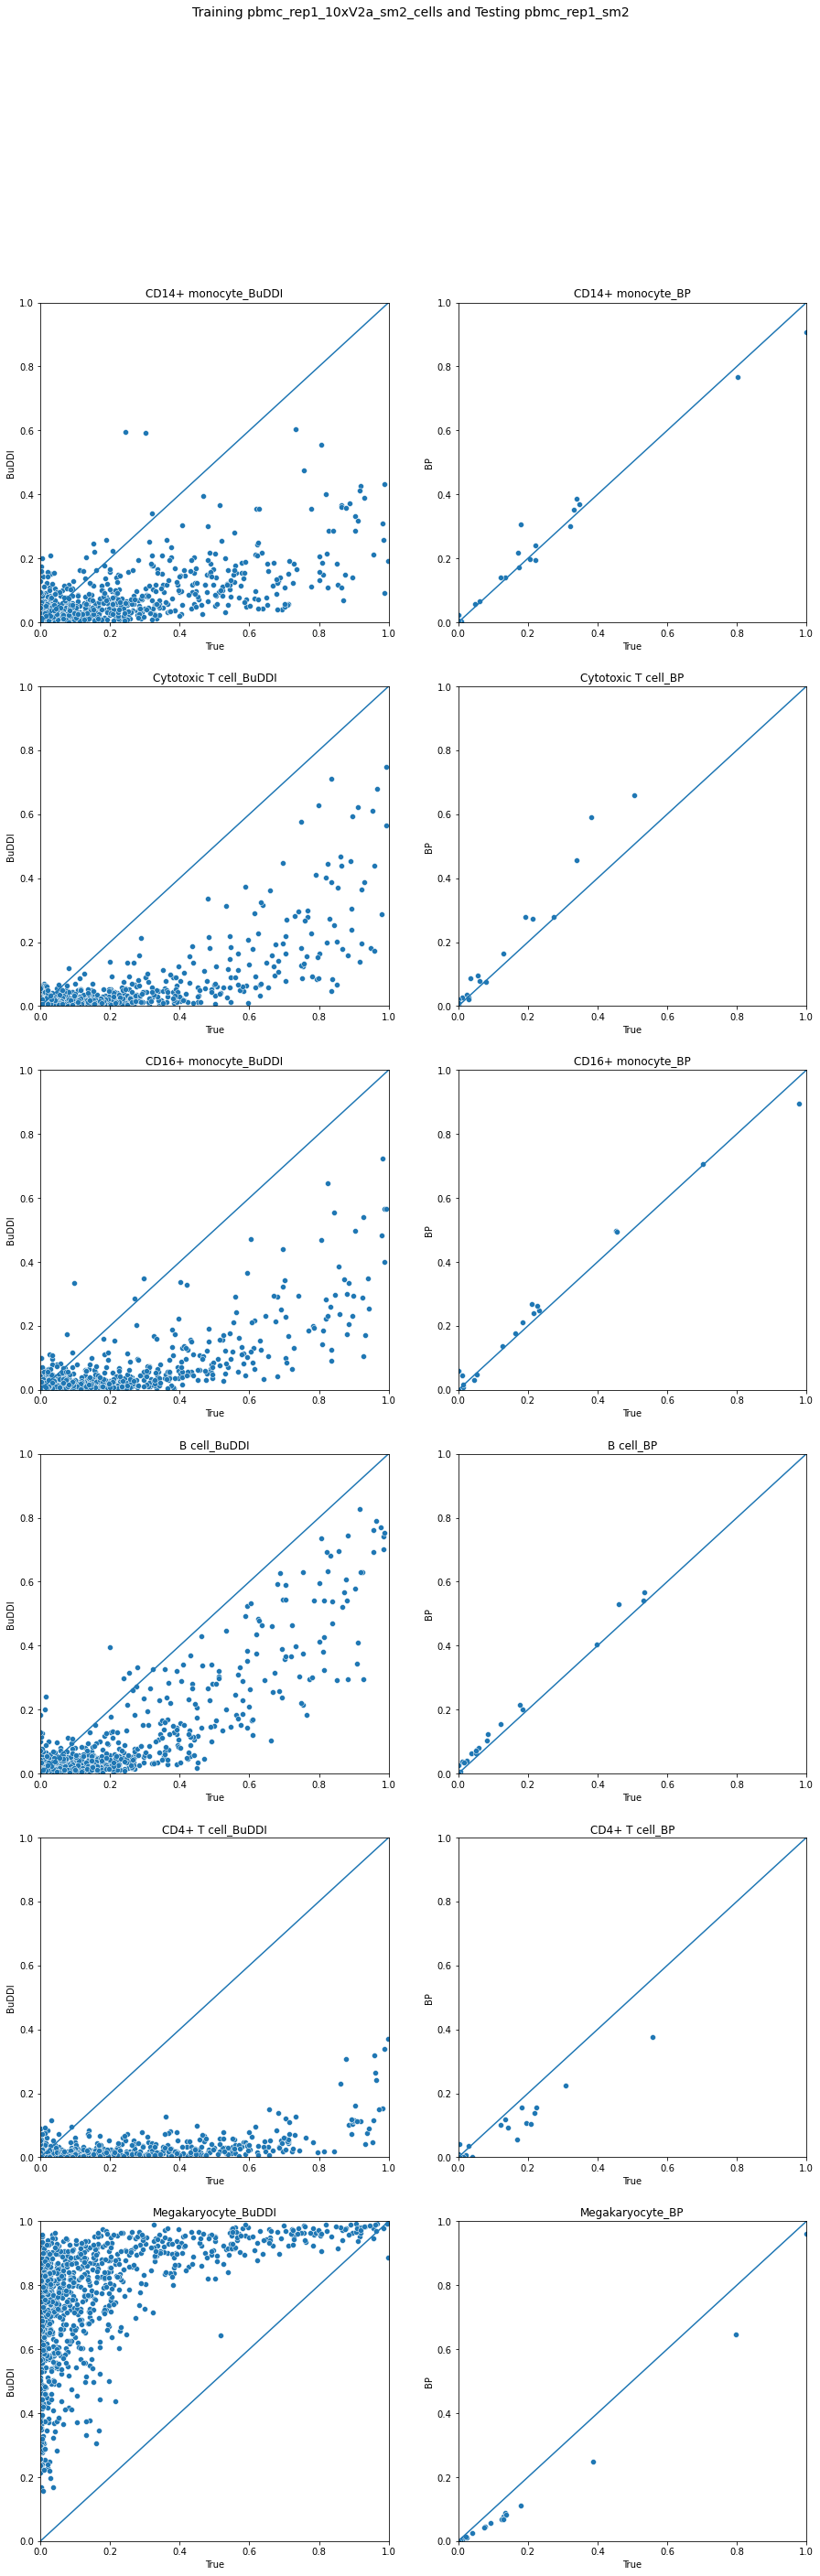

In [26]:
num_samp_bp = 20
train_id = "pbmc_rep1_10xV2a_sm2_cells"
test_id = "pbmc_rep1_sm2"
plot_df, Y_test_df, within_sample_test_diva, within_sample_test_bp = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id)

fig, axs = plt.subplots(6, 2, figsize=(15,45))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle(f"Training {train_id} and Testing {test_id}", fontsize=14)

fig.show()

In [27]:
num_samp_bp = 20
train_id = "pbmc_rep1_sm2"
test_id = "pbmc_rep2_10xV2_sm2_cells"
plot_df, Y_test_df, within_sample_test_diva, within_sample_test_bp = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id)


MSqE mean: 0.11669822075810114, median: 0.12332441420884424, max: 0.28964247098351964
Spearman mean: 0.2759799026100177, median: 0.3142857142857143, max: 1.0
Pearson mean: 0.07878355407391864, median: -0.05937132703036173, max: 0.9999673264762237
MSqE mean: 0.028085307436373004, median: 0.025777655272452946, max: 0.07496888488293775
Spearman mean: 0.33884089518414856, median: 0.4285714285714286, max: 0.942857142857143
Pearson mean: 0.4219138979329492, median: 0.6923527181532003, max: 0.9914307613018953


In [28]:
num_samp_bp = 20
train_id = "pbmc_rep1_sm2"
test_id = "pbmc_rep1_10xV2a_sm2_cells"
plot_df, Y_test_df, within_sample_test_diva, within_sample_test_bp = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id)


MSqE mean: 0.1091796989152691, median: 0.1129397795161319, max: 0.2987155472056077
Spearman mean: 0.3338463119744434, median: 0.3714285714285715, max: 1.0
Pearson mean: 0.14689843274109443, median: 0.028196112587260933, max: 0.9999715488303763
MSqE mean: 0.02017295511549371, median: 0.019529996601224772, max: 0.04377658299687399
Spearman mean: 0.5399299141169875, median: 0.6285714285714286, max: 0.942857142857143
Pearson mean: 0.6796667378119594, median: 0.7874651133908456, max: 0.9874693318460465


In [29]:
# across rep and tech
within_sample_test_diva  = read_diva_result_file(res_path, "pbmc_rep1_sm2", "pbmc_rep2_10xV2_sm2_cells")
within_sample_test_bp  = read_bp_result_file(bp_res_path, "pbmc_rep1_sm2_0", "pbmc_rep2_10xV2_sm2_cells_0", num_samp=1000)
within_sample_test_bp = within_sample_test_bp.reindex(columns=within_sample_test_diva.columns, fill_value=0)

X_test, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 0, "pbmc_rep2_10xV2_sm2_cells")

Y_test_df = Y_test_df.reindex(columns=within_sample_test_diva.columns, fill_value=0)
Y_test = Y_test_df.to_numpy()

biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())
#biorep_diva_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_diva.to_numpy()))
#biorep_bp_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_bp.to_numpy()))

biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

plot_df = pd.concat([biorep_diva_err, biorep_bp_err])
#plot_df = biorep_diva_err

fig, axs = plt.subplots(1, 2, figsize=(15,7))

sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
fig.suptitle("Training on pbmc_rep2_10xV2 and Testing on pbmc_rep1_sm2", fontsize=14)

fig.show()




FileNotFoundError: [Errno 2] No such file or directory: '/beevol/home/davidson/checkouts/sc_bulk_ood/evaluation_experiments/pbmc/../../results/single_cell_data/bp_pbmc/train-pbmc_rep1_sm2_0-test-pbmc_rep2_10xV2_sm2_cells_0-bp_1000_prop.tsv'

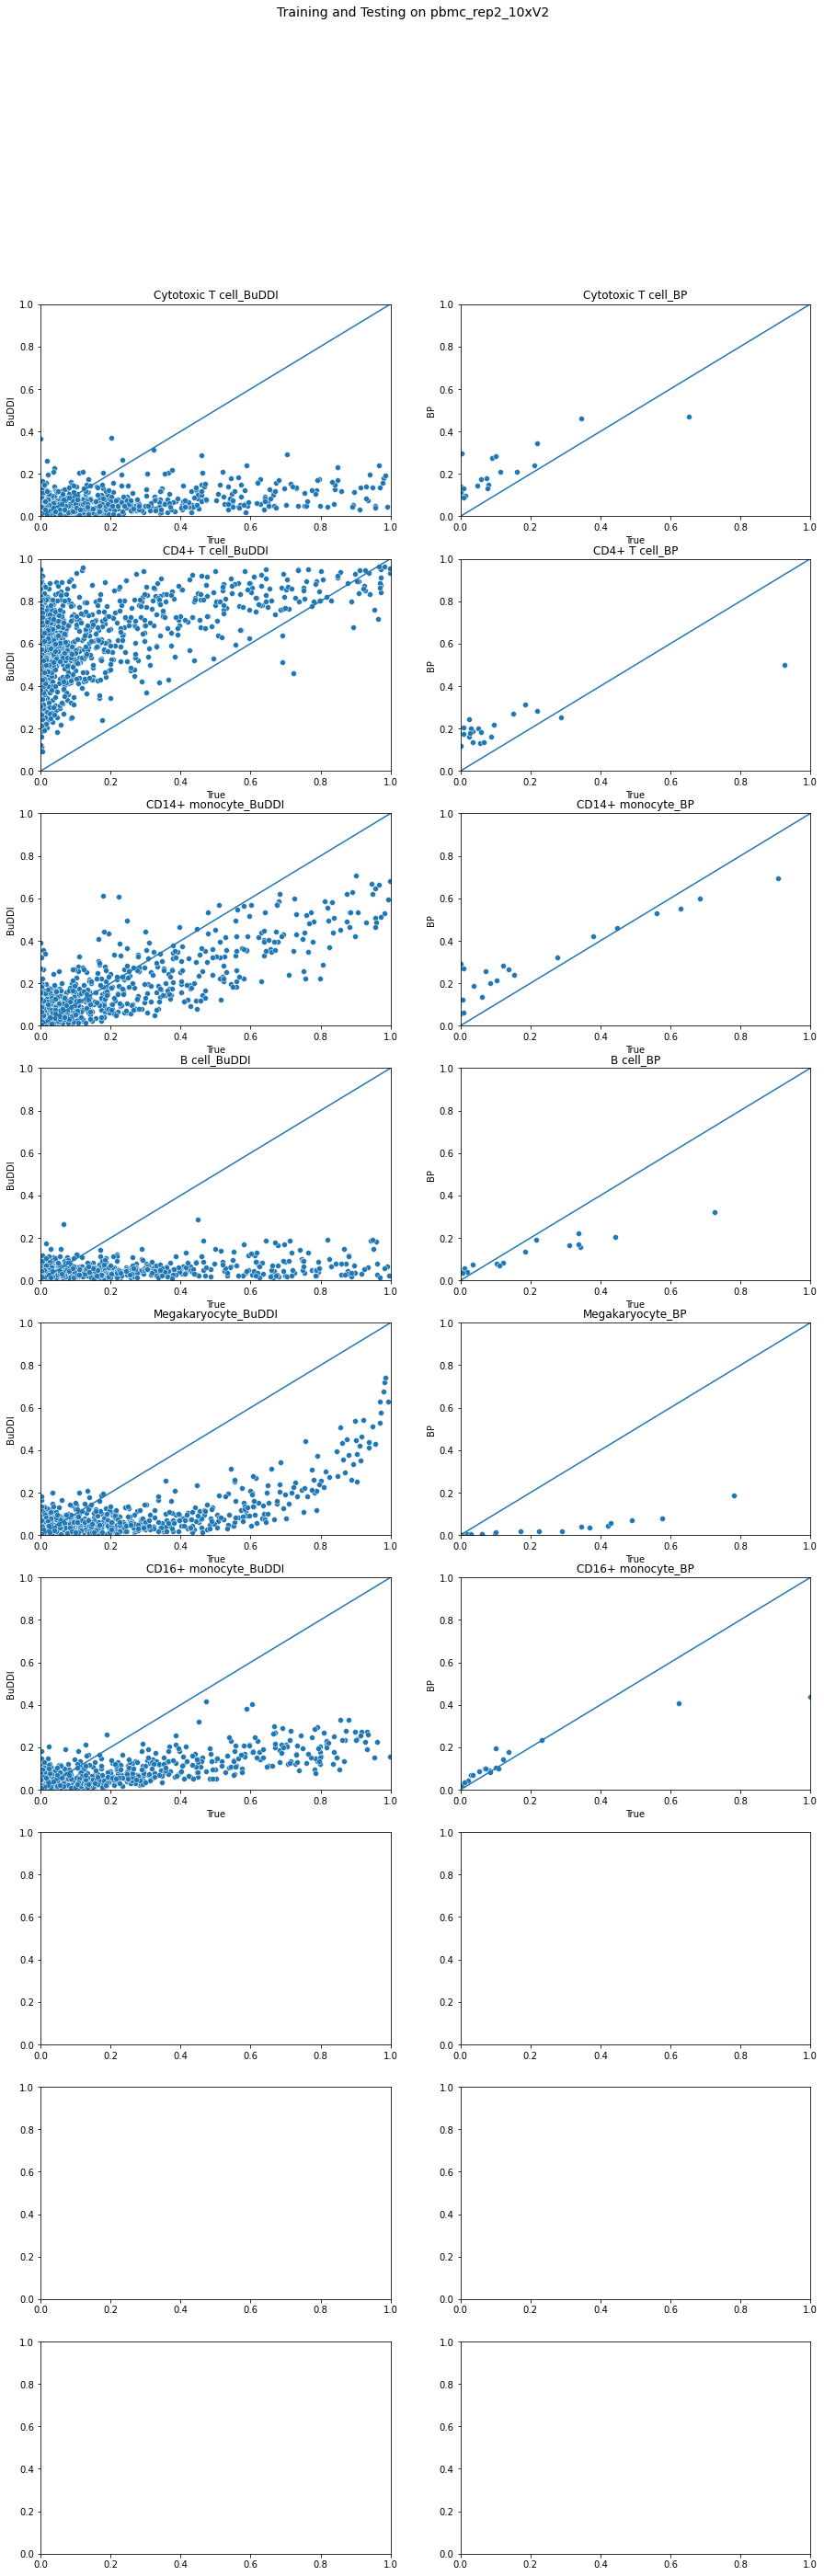

In [ ]:

fig, axs = plt.subplots(9, 2, figsize=(15,45))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()



MSqE mean: 0.03708161956580395, median: 0.025755505786811694, max: 0.24874359818860545
Spearman mean: 0.3679531545010736, median: 0.4285714285714286, max: 1.0
Pearson mean: 0.5305270858921401, median: 0.6813280670527115, max: 0.999989880145551
MSqE mean: 0.0027103953282401785, median: 0.0017918456507882608, max: 0.012946722760942228
Spearman mean: 0.81992722483249, median: 0.8857142857142858, max: 1.0
Pearson mean: 0.9429497380692432, median: 0.9800957540672417, max: 0.9997650647225015


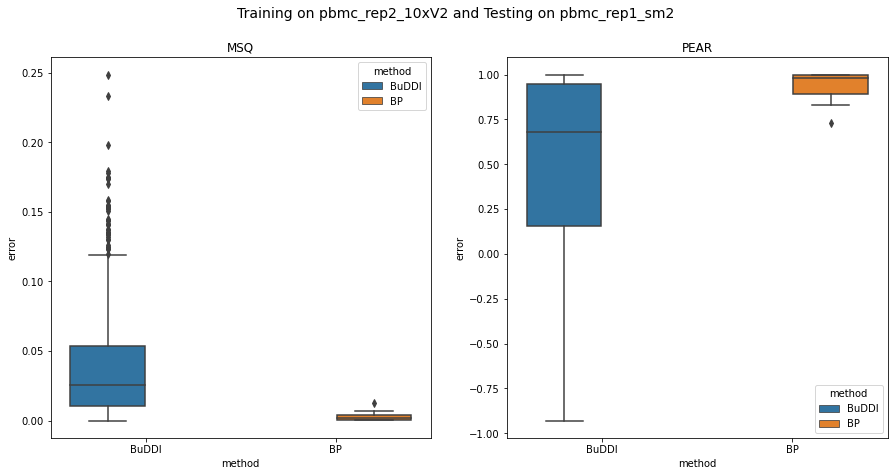

In [ ]:
# test cross opposite reps
within_sample_test_diva  = read_diva_result_file(res_path, "pbmc_rep1_10xV2a_sm2_cells", "pbmc_rep1_sm2")
within_sample_test_bp  = read_bp_result_file(bp_res_path, "pbmc_rep1_10xV2a_sm2_cells_0", "pbmc_rep1_sm2_0", num_samp=20)
within_sample_test_diva = within_sample_test_diva.reindex(columns=within_sample_test_bp.columns, fill_value=0)

X_test, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 0, "pbmc_rep1_sm2")


Y_test_df = Y_test_df.reindex(columns=within_sample_test_bp.columns, fill_value=0)
Y_test = Y_test_df.to_numpy()


biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())

biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

plot_df = pd.concat([biorep_diva_err, biorep_bp_err])
#plot_df = biorep_diva_err

fig, axs = plt.subplots(1, 2, figsize=(15,7))

sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
fig.suptitle("Training on pbmc_rep2_10xV2 and Testing on pbmc_rep1_sm2", fontsize=14)

fig.show()

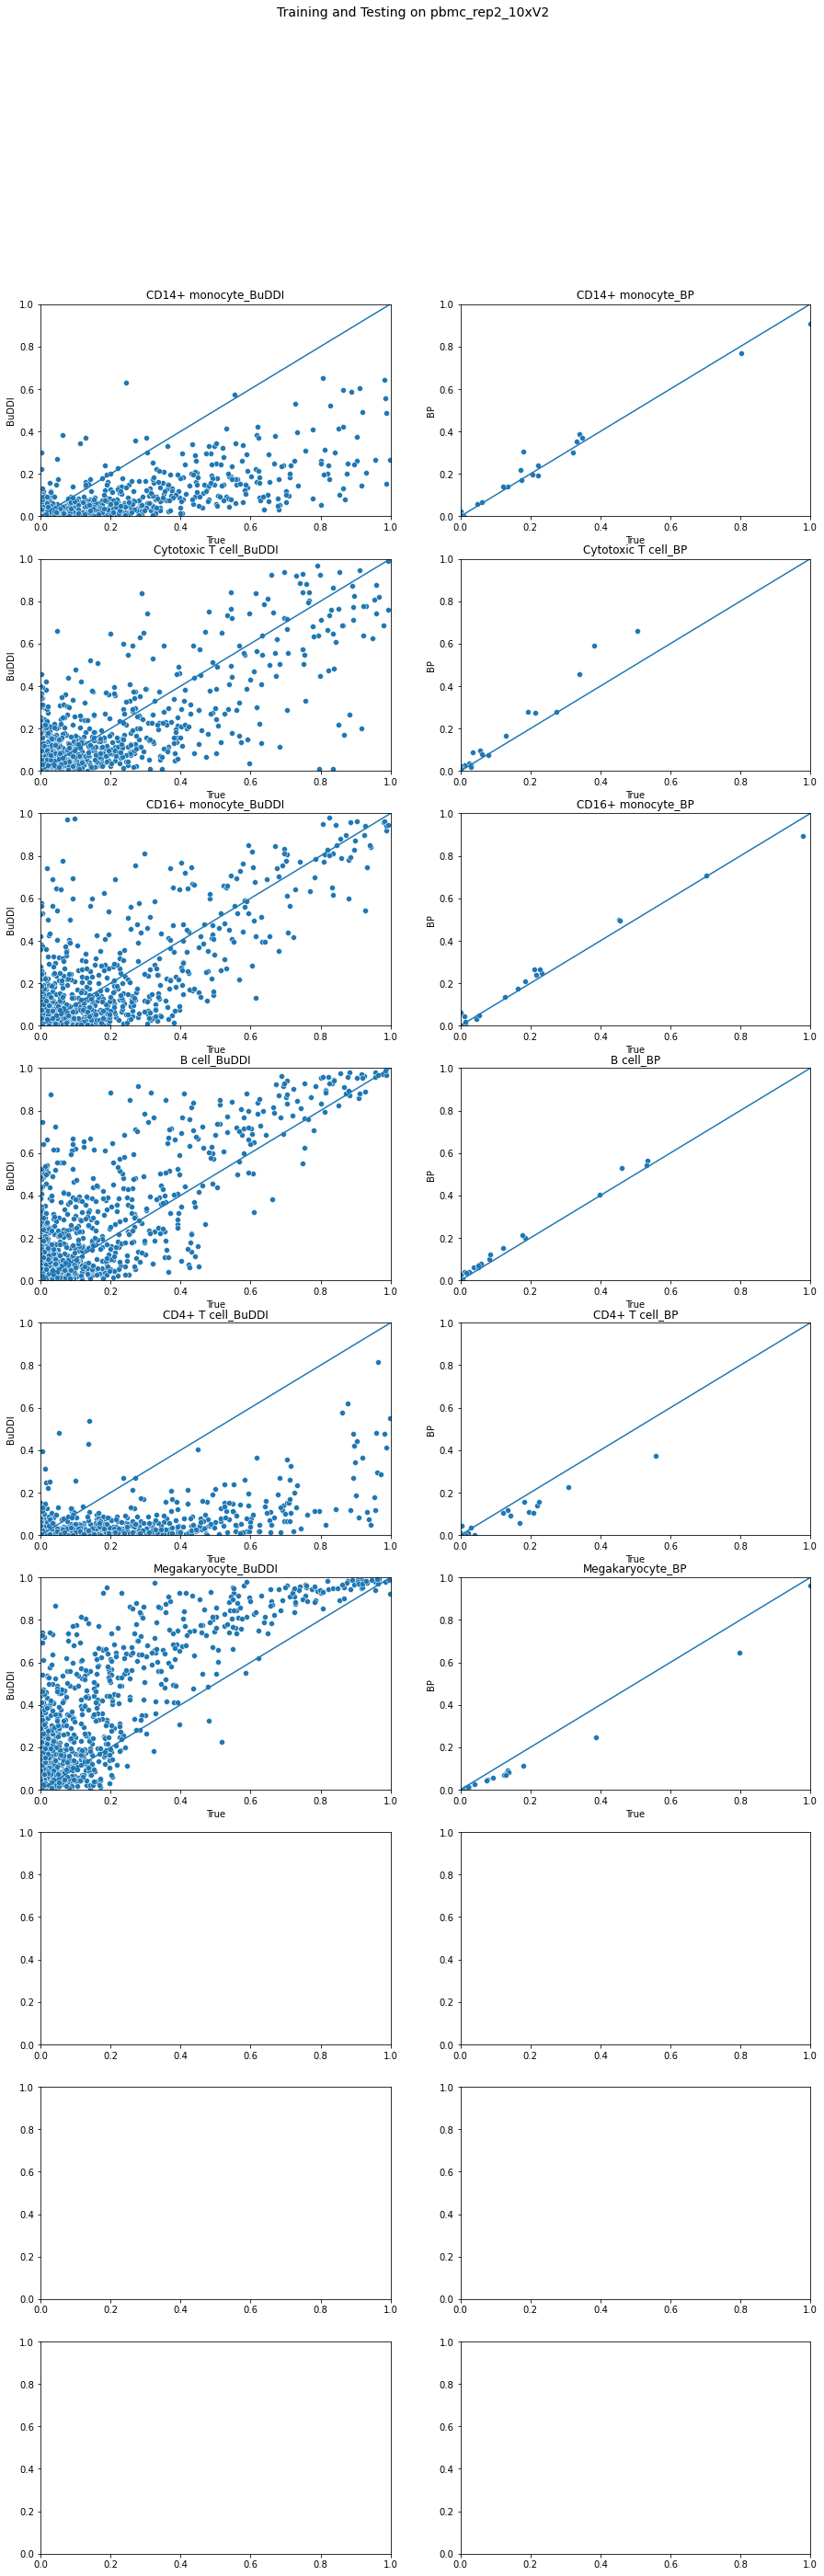

In [ ]:
fig, axs = plt.subplots(9, 2, figsize=(15,45))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

In [ ]:
Y_test_df.head()
print(Y_test_df.iloc[[1]])
print(within_sample_test_bp.iloc[[1]])

  CD14+ monocyte Cytotoxic T cell CD16+ monocyte    B cell CD4+ T cell  \
0        0.06029         0.025307       0.230741  0.532936    0.020841   

  Megakaryocyte  
0      0.129885  
   CD14+ monocyte  Cytotoxic T cell  CD16+ monocyte    B cell  CD4+ T cell  \
1         0.06688          0.034129        0.248722  0.565753     0.007214   

   Megakaryocyte  
1       0.077302  


In [ ]:
Y_test_df.head()
np.abs(Y_test_df.iloc[2] - within_sample_test_diva.iloc[2])

CD14+ monocyte      0.540051
Cytotoxic T cell    0.022558
CD16+ monocyte       0.02228
B cell              0.124012
CD4+ T cell         0.003605
Megakaryocyte       0.367596
dtype: object

In [ ]:
Y_test_df.head()

CD14+ monocyte Cytotoxic T cell CD16+ monocyte    B cell CD4+ T cell  \
0       0.222222         0.000717       0.703226   0.03871    0.030108   
0        0.06029         0.025307       0.230741  0.532936    0.020841   
0       0.801527         0.079676       0.011927  0.081584     0.00334   
0       0.171594         0.011887       0.209997  0.085645    0.133496   
0       0.174518         0.273555       0.127409  0.396949    0.012848   

  Megakaryocyte  
0      0.005018  
0      0.129885  
0      0.021947  
0      0.387382  
0      0.014722

In [ ]:
within_sample_test_diva.head()

CD14+ monocyte  Cytotoxic T cell  CD16+ monocyte    B cell  CD4+ T cell  \
0        0.043520          0.012168        0.807793  0.031318     0.016160   
1        0.020900          0.036618        0.064047  0.773314     0.004263   
2        0.261476          0.102233        0.034208  0.205596     0.006945   
3        0.038454          0.081195        0.103351  0.079542     0.012558   
4        0.073652          0.023162        0.340004  0.498690     0.000607   

   Megakaryocyte  
0       0.089041  
1       0.100857  
2       0.389542  
3       0.684900  
4       0.063885